In [73]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as mpl

from collections import defaultdict
from functools import reduce
from path import Path
from pprint import pprint
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 16,6

# 7.1

Why is shuffling a dataset before conducting a k-fold CV generall a bad idea in finance? What is the purpose of shuffling? Why does shuffling defeat the purpose of k-fold CV in financial datasets?

**A: Markets are adaptive systems and thus sample order is meaningful. Generally we would shuffle data because we don't want the model to make predictions based on the order of the data.**

In [3]:
from sampling import dollar_bars
from filters import cusum
from multiprocess import mpPandasObj
from load_data import load_contracts
from labeling import getEvents, getVerticalBarriers, getBins
from util import getDailyVol

In [4]:
es_contracts = load_contracts('@ES')

# 7.2a

Take a pair of matrices (X, y) representing observed features and labels. These could be one of the datasets derived from the exercises in Chapter 3.

Derive the performance from a 10-fold CV of an RF classifier on (X, y), without shuffling.

In [5]:
dbars = dollar_bars(es_contracts, 100000000)

df = dbars.copy()['2018-8-1':'2019-5-1']
close = df['Close']
daily_vol = getDailyVol(close)
tEvents = cusum(close, getDailyVol(close).mean())
t1 = getVerticalBarriers(close, tEvents, numDays=1)
events = getEvents(close, tEvents=tEvents, ptSl=[1,1], t1=t1, trgt=daily_vol, minRet=0.01)

close = df['Close']
fast_ma = close.rolling(50).mean()
slow_ma = close.rolling(200).mean()

long_signals = (fast_ma >= slow_ma)
short_signals = (fast_ma < slow_ma)

df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1
events['side'] = df['side']

bins = getBins(events, df['Close'])
bins['bin'].value_counts()

df['log_ret'] = np.log(close).diff()
df['vol5'] = df['log_ret'].rolling(5).std()
df['vol10'] = df['log_ret'].rolling(10).std()

df['serialcorr20-1'] = df['log_ret'].rolling(20).apply(lambda x: pd.Series(x).autocorr(lag=1))


df = df.shift()

from sklearn.ensemble import RandomForestClassifier

train_features = df.loc[events.index][['side', 'vol5', 'serialcorr20-1']]
train_labels = bins['bin']

rf = RandomForestClassifier(n_estimators=512, random_state=42, max_depth=5, oob_score=True)
rf.fit(train_features, train_labels)

C:\Users\doda\Dropbox\algotrading\AFML\labeling.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  trgt = trgt.loc[tEvents]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [6]:
from sklearn.model_selection import cross_validate, KFold

cvd = cross_validate(rf, train_features, train_labels, cv=KFold(10))

In [7]:
cvd['test_score'].mean()

0.6983229813664596

# 7.2b

Take a pair of matrices (X, y) representing observed features and labels. These could be one of the datasets derived from the exercises in Chapter 3.

Derive the performance from a 10-fold CV of an RF classifier on (X, y), with shuffling.

In [8]:
cvd = cross_validate(rf, train_features, train_labels, cv=KFold(10, shuffle=True))

In [9]:
cvd['test_score'].mean()

0.7011180124223603

# 7.2c

Take a pair of matrices (X, y) representing observed features and labels. These could be one of the datasets derived from the exercises in Chapter 3.

Why are both results so different?

**A: Shuffling introduces information from the future into our training set.**

# 7.2d

Take a pair of matrices (X, y) representing observed features and labels. These could be one of the datasets derived from the exercises in Chapter 3.

How does shuffling leak information?

**A: The model is able to train on data from the future.**

# 7.3a

Take the same pair of matrices (X, y) you used in exercise 2.

Derive the performance from a 10-fold purged CV of an RF on (X, y), with 1% embargo.

In [70]:
from sklearn.model_selection._split import _BaseKFold
from sklearn.metrics import log_loss, accuracy_score
from cv import cvScore

cvd = cvScore(rf, train_features, train_labels, pctEmbargo=0.01,
              sample_weight=None, cv=10,
              t1=pd.Series(train_features.index, index=train_features.index),
              scoring='accuracy'
             )
print("The mean CV performance is {:.2f}.".format(np.mean(cvd)))


The mean CV performance is 0.70.


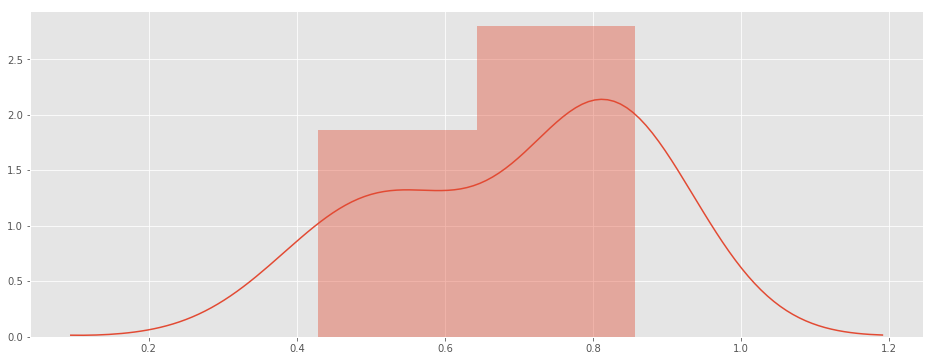

In [72]:
# Just for fun
sns.distplot(cvd);

# 7.4

In this chapter we have focused on one reason why k-fold CV fails in financial applications, namely the fact that some information from the testing set leaks into the training set. Can you think of a second reason for CV's failure?

**A: Overfitting due to multiple train/test bias (explored further in chapters 11-13)**

# 7.5

Suppose you try one thousand configurations of the same investment strategy, and perform CV on each of them. Some results are guaranteed to look good, just by sheer luck. If you only publish those positive, and hide the rest, your audience will not be able to deduce that these results are false positives, a statistical fluke. This phenomenon is called "selection bias."

- a) Can you imagine one procedure to prevent this?

- **A: Publish the amount of trials it took to get the results**

- b) What if we split the dataset in three sets: training, validation, and testing? The validation set is used to evaluate the trained parameters, and the testing is run only on the one configuration chosen in the validation phase. In what case does this procedure still fail?

- **A: If repeatedly test against the 3rd set, we can still bias our results.**

- c) What is the key to avoiding selection bias?

- **A: Taking the number of trials into account and not using backtests as a research tool.**